In [ ]:
# Installing 3 libraries
!pip install category_encoders
!pip install pdpbox
!pip install shap

In [59]:
# Importing necessary libraries and packages
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from category_encoders import OrdinalEncoder, OneHotEncoder

In [60]:
# Mounting my Google Drive to Colab so I don't have to upload the .csv file
# each time I open the project.  However, I have included the link to where the
# file can be downloaded below...
#
# https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
# Reading my file into a pandas DataFrame using proper encoding, converting the
# 'Date' column to a datetime format and setting it as the index, and sorting
# the Dataframe first by 'Date', and then by 'Hour', so all of the data is in
# chronological order

df = pd.read_csv('/content/drive/MyDrive/SeoulBikeData (1).csv', encoding='unicode_escape', parse_dates=['Date'], index_col='Date').sort_values(by=['Date', 'Hour'])

In [81]:
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
Date,,,,,,,,,,,,,
2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [135]:
# Convert Datetime index to specific day of the year represented with an integer

df['Day of Week'] = df.index.dayofweek

In [136]:
# Every non-functioning day has a 'Rented Bike Count' of 0.  This information is
# not useful since we are trying to predict how many bikes will be rented when 
# the business is open.  For this reason we can remove these observations and 
# drop the 'Functioning Day' column

df = df[df['Functioning Day'] != 'No']
df.drop(columns='Functioning Day', inplace=True)

In [137]:
# After creating initial models, 'Holiday' seemed to have no importance, and 
# 'Dew point' was highly correlated with 'temperature'.  For this reason, both
# were dropped and accuracy score remained the same

df.drop(columns=['Dew point temperature(°C)', 'Holiday'], inplace=True)

In [138]:
# Separating data into feature matrix (X) and target vector (y) with the target
# being 'Rented Bike Count'

target = "Rented Bike Count"

X = df.drop(columns=target)
y = df[target]

In [130]:
# Splitting the data into training (80%) and test (20%) sets.  Since I will be
# using cross validation to measure accuracy, we will not need an additional
# validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state=42)

In [131]:
# Baseline estimate for 'Rented Bike Count' during any given hour of any given
# day is approximately 735 bikes

baseline_acc = y_train.mean()
print('Average Bike Rentals on any given day:', round(baseline_acc, 1))

Average Bike Rentals on any given day: 734.6


In [113]:
# Using the average above, we can create an array of predictions so that we
# can perform statistical measures like MAE, MSE, and R2.  Here we see the R2
# score is 0 since our predictions form a flat, horizontal line

y_pred_baseline = [baseline_acc] * len(X_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred_baseline))
print('Baseline MSE:', mean_squared_error(y_train, y_pred_baseline))
print('Baseline R2:', r2_score(y_train, y_pred_baseline))

Baseline MAE: 524.6001306934604
Baseline MSE: 424677.64885186177
Baseline R2: 0.0


In [95]:
# Building Linear Model with a One Hot Encoder and Standard Scaler

lr_model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(with_mean=False),
    LinearRegression()
)

lr_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Seasons'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [96]:
# Checking Linear Regression Model Metrics for the Training Data

y_pred_train_lr = lr_model.predict(X_train)
print('Linear Regression - Training Metrics')
print('MAE:', mean_absolute_error(y_train, y_pred_train_lr))
print('MSE:', mean_squared_error(y_train, y_pred_train_lr))
print('R2:', cross_val_score(lr_model, X_train, y_train, cv=5, n_jobs=-1).mean())

Linear Regression - Training Metrics
MAE: 328.3305385878371
MSE: 193085.46937527522
R2: 0.5377129814010104


In [97]:
# Building an XGB Model with Ordinal Encoder

xgb_model = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor(
        random_state=42,
        n_jobs = -1
    )
)

xgb_model.fit(X_train, y_train)

[21:52:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Seasons'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'Seasons',
                                          'data_type': dtype('O'),
                                          'mapping': Summer    1
Spring    2
Autumn    3
Winter    4
NaN      -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=-1,
                    

In [98]:
# Checking XGB Regression Model Metrics on Training Data

y_pred_train_xgb = xgb_model.predict(X_train)
print('XGB Regression - Training Metrics')
print('MAE:', mean_absolute_error(y_train, y_pred_train_xgb))
print('MSE:', mean_squared_error(y_train, y_pred_train_xgb))
print('R2:', cross_val_score(xgb_model, X_train, y_train, cv=5, n_jobs=-1).mean())

XGB Regression - Training Metrics
MAE: 154.5466198617019
MSE: 55482.06462018464
R2: 0.8180928502951854


In [114]:
# Building Random Forest Model with an Ordinal Encoder

rf_model = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor(
        random_state=42,
        max_features=7,
        min_samples_split=2,
        min_samples_leaf=2,
        n_estimators=160,
        max_depth=21
    )
)

rf_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Seasons'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'Seasons',
                                          'data_type': dtype('O'),
                                          'mapping': Summer    1
Spring    2
Autumn    3
Winter    4
NaN      -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=21,
                                       max_features=7, max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                             

In [115]:
# Checking Random Forest Model Metrics on Training Data

y_pred_train_rf = rf_model.predict(X_train)
print('Random Forest - Training Metrics')
print('MAE:', mean_absolute_error(y_train, y_pred_train_rf))
print('MSE:', mean_squared_error(y_train, y_pred_train_rf))
print('R2:', cross_val_score(rf_model, X_train, y_train, cv=5, n_jobs=-1).mean())

Random Forest - Training Metrics
MAE: 78.404794900178
MSE: 15755.719832514382
R2: 0.8363687200370717


In [116]:
# After model was selected, checked model performance on the unseen Test Data

y_pred_test_rf = rf_model.predict(X_test)
print('Random Forest - Test Metrics')
print('MAE:', mean_absolute_error(y_test, y_pred_test_rf))
print('MSE:', mean_squared_error(y_test, y_pred_test_rf))
print('R2:', r2_score(y_test, y_pred_test_rf))

Random Forest - Test Metrics
MAE: 157.0028031429146
MSE: 58428.2280760414
R2: 0.8573283275763577


In [251]:
# Random Forest Hyperparameter Tuning using Randomized Search CV.  Looking for
# optimal solutions for the parameters listed in the 'param_grid' below

clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor(
        random_state=42,
        max_features=7,
        min_samples_split=2,
        min_samples_leaf=2
    )
)

param_grid = {
    'randomforestregressor__n_estimators': range(160, 210, 10),
    'randomforestregressor__max_depth': range(25, 35, 1),
    'randomforestregressor__min_samples_split': range(2, 5, 1),
    'randomforestregressor__min_samples_leaf': range(1, 5, 1),
    'randomforestregressor__max_features': range(4, 10, 1),
}

rf_model_rs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_iter = 50,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

rf_model_rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                      

In [252]:
# Randomized Search Best Params
rf_model_rs.best_params_

{'randomforestregressor__max_depth': 29,
 'randomforestregressor__max_features': 7,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 4,
 'randomforestregressor__n_estimators': 190}

In [253]:
# Randomized Search Best R2 Score
rf_model_rs.best_score_

0.8340698638633788

In [117]:
# Identifying the feature importances of the random forest model that was just 
# tuned.  Putting the importances into a series and sorting them from least important
# to most important.  Temperature, at the bottom, is the most important feature

importances = rf_model.named_steps['randomforestregressor'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

Snowfall (cm)              0.000317
Day of Week                0.017895
Visibility (10m)           0.022520
Wind speed (m/s)           0.023990
Rainfall(mm)               0.030569
Seasons                    0.068526
Solar Radiation (MJ/m2)    0.083254
Humidity(%)                0.098953
Hour                       0.323181
Temperature(°C)            0.330796
dtype: float64

In [118]:
# Performing permutation importances on each feature to see how this compares
# with the model's feature importances.  The 2 reports have a couple features 
# which are flipped, but for the most part, the order of importance for each
# report matches up well

perm_imp = permutation_importance(rf_model, X_train, y_train, random_state=42)
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}
df_perm = pd.DataFrame(data, index=X_train.columns).sort_values(by='imp_mean')

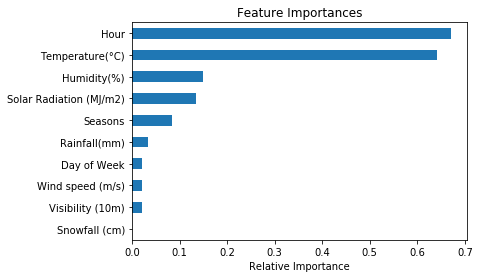

In [119]:
# Plotting permutation importances which were calculated above using a horizontal
# bar graph

df_perm['imp_mean'].plot(kind='barh')
plt.xlabel('Relative Importance')
plt.title('Feature Importances');

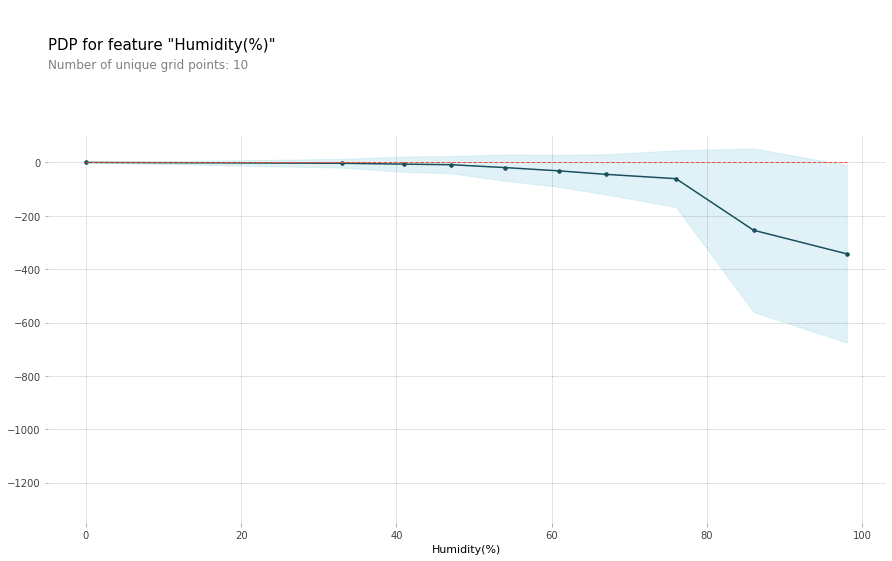

In [120]:
# Using partial dependence plots to isolate individual features and get a better
# of understanding of the direction and magnitude of their importance

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
isolate = pdp_isolate(
    rf_model,
    dataset = X_train,
    model_features = X_train.columns,
    feature = 'Humidity(%)'
)

pdp_plot(isolate, feature_name = 'Humidity(%)');

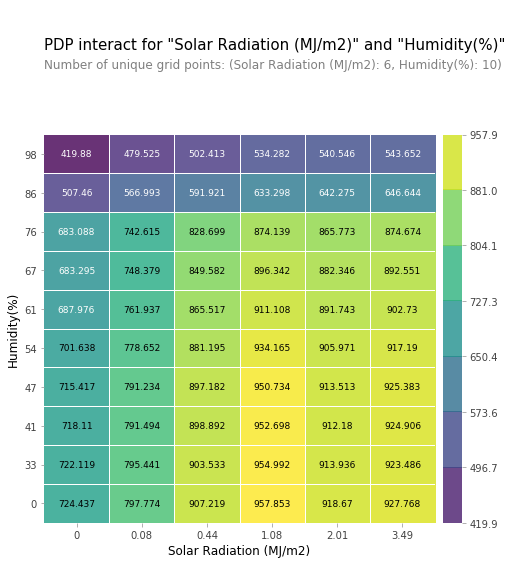

In [121]:
# Using interaction plots to see how 2 features may be interacting to affect
# predictions.  Below is a look at how 'Humidity' and 'Solar Radiation' are 
# interacting to affect 'Rented Bikes Count'

features = ['Solar Radiation (MJ/m2)', 'Humidity(%)']
interact = pdp_interact(
    rf_model,
    dataset = X_train,
    model_features = X_train.columns,
    features = features
)

pdp_interact_plot(interact, plot_type = 'grid', feature_names = features);

In [139]:
# This entire code block is to appease the shapley package.  Shapley won't accept
# pipelines, and shapley won't accept categorical features.  The purpose 
# of this code block is to make a copy of my dataframe and do the ordinal encoding 
# manually so that I can successfully access the shapley tools

target = 'Rented Bike Count'

# Creating a new column 'Season' by mapping the 4 seasons in 'Seasons' to integers
# and then dropping the 'Seasons' column
df_copy = df
df_copy['Season'] = df_copy['Seasons'].replace({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3})
df_copy.drop(columns='Seasons', inplace=True)

# Creating FM and TV
X_shap = df_copy.drop(columns=target)
y_shap = df_copy[target]

# Creating Test and Training splits
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y_shap, test_size = 0.8, random_state=42)

# Creating a model which is intentionally not part of a pipeline
rf_model_shap = RandomForestRegressor(
        random_state=42,
        max_features=7,
        min_samples_split=2,
        min_samples_leaf=2,
        n_estimators=160,
        max_depth=21
)

rf_model_shap.fit(X_train_shap, y_train_shap)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=21, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [141]:
# UImporting Shapley, and then extracting one obervation from my data set

import shap
samp = X_train_shap.iloc[248]
samp

Hour                         14.0
Temperature(°C)              35.8
Humidity(%)                  49.0
Wind speed (m/s)              2.8
Visibility (10m)           1264.0
Solar Radiation (MJ/m2)       2.4
Rainfall(mm)                  0.0
Snowfall (cm)                 0.0
Day of Week                   1.0
Season                        2.0
Name: 2018-07-24 00:00:00, dtype: float64

In [143]:
# Using Shapley to create a Force Plot demonstrating how each feature is affecting the 
# prediction for specific observation

explainer = shap.TreeExplainer(rf_model_shap)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = samp
)

100%|===================| 1689/1693 [01:03<00:00]       

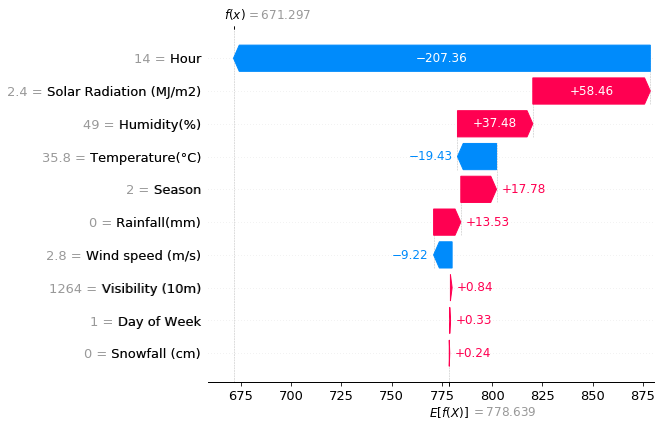

In [144]:
# Similar to the model above, but with a new stacked layout which is easier
# for some people to digest

explainer = shap.TreeExplainer(rf_model_shap, X_train_shap)
shap_values = explainer(X_train_shap, check_additivity=False)
shap.plots.waterfall(shap_values[248])